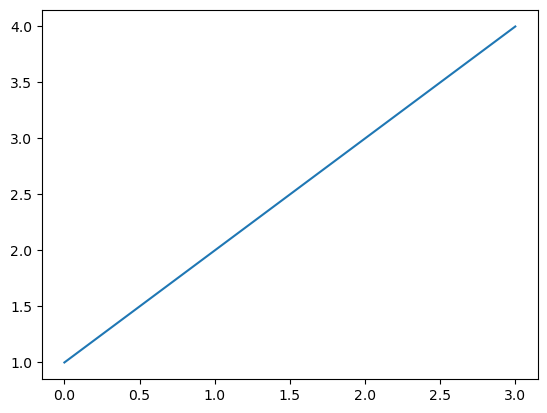

In [1]:
import matplotlib.pyplot as plt
num = [1, 2, 3, 4]

plt.plot(num)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os 
import glob

from PIL import Image
from torch import tensor
from sklearn.preprocessing import LabelEncoder

print("Libraries imported successfully")

Libraries imported successfully


In [3]:
#set the hyperparameters
lr = 0.001
batch_size = 32
epochs = 10

In [4]:
#set seed and random value
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
#get the directory
base_dir = "C:\\Users\\aliab\\OneDrive\\Desktop\\Bone Fracture Final Project"

#base_dir = "C:\\Users\\Lenovo\\Desktop\\Tumor\\" this can also be used


train_data_path = "C:\\Users\\aliab\\OneDrive\\Desktop\\Bone Fracture Final Project\\train"

valid_data_path = "C:\\Users\\aliab\\OneDrive\\Desktop\\Bone Fracture Final Project\\valid"

test_data_path = "C:\\Users\\aliab\\OneDrive\\Desktop\\Bone Fracture Final Project\\test"

In [6]:
def read_folder_data(base_dir):
    labels = []
    images = []
    
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg'):
                label = file.split('_')[0]
                image = os.path.join(root, file)
                labels.append(label)
                images.append(image)
                
    df = pd.DataFrame({'label': labels, 'image': images})
    return df

In [7]:
train_data = read_folder_data(train_data_path)

valid_data = read_folder_data(valid_data_path)

test_data = read_folder_data(test_data_path)

combined_data = pd.concat([train_data, valid_data, test_data])

In [8]:
combined_data.to_csv('combined_labels_and_images.csv', index=False)

In [9]:
#check the list of dataset in the train
len(train_data), len(valid_data), len(test_data)

(3631, 348, 169)

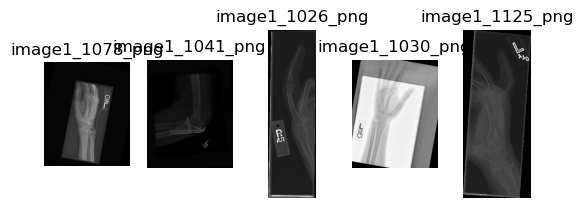

In [10]:


#check the database
random_idx = np.random.randint(1, 188, size=5)

fig = plt.figure()
i = 1
for idx in random_idx:
    ax = fig.add_subplot(2, 5, i)
    image_data = train_data.iloc[idx]['image']
    img = Image.open(image_data)
    ax.imshow(img)
    ax.set_title(train_data.iloc[idx]['image'].split('/')[-1].split(".")[0].split("\\")[-1])
    ax.axis('off')
    i += 1
    
plt.show()

In [11]:
#train_data.iloc[0].str.split('/')[-1].str.split(".")[0].str.split("\\")[-1]
[s.split('/')[-1].split(".")[0].split("\\")[-1] for s in train_data]

['label', 'image']

In [12]:
print(len(train_data), len(valid_data), len(test_data))

3631 348 169


In [13]:
#augment the data
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

valid_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])


In [14]:


# load the data
#class dataset(torch.utils.data.Dataset):
 #   def __init__(self, file_list, transform=None):
  #      self.file_list = file_list
   #     self.transform = transform
        
    #dataset length
    #def __len__(self):
     #   self.filelength = len(self.file_list)
      #  return self.filelength
    
    #load one of the images
 #   def __getitem__(self, idx):
  #      img_path = self.file_list.iloc[idx]['image']
   #     img = Image.open(img_path)
    #    img_transformed = self.transform(img)
        
     #   label = img_path.split('/')[-1].split(".")[0].split("\\")[-1]
      #  if label == "fracture":
       #     label = 0
        #elif label == "no_fracture":
         #   label = 1
            
            
        #return img_transformed, label
    
    
class CustomDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.label_encoder = LabelEncoder()
        # Fit the label encoder with all unique labels
        self.label_encoder.fit(file_list['label'].unique())
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list.iloc[idx]['image']
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        
        label = self.file_list.iloc[idx]['label']
        # Transform the label to a numerical value
        label = self.label_encoder.transform([label])[0]
        
        return img, label

In [15]:
#print(f"Label for index {idx}: {label}")

In [16]:
#get the dataset loaded
train_dataset = CustomDataset(train_data, transform=train_transforms)
valid_dataset = CustomDataset(valid_data, transform=valid_transforms)
test_dataset = CustomDataset(test_data, transform=test_transforms)

In [17]:
#use the Dataloader to load all the images
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset = valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=True)

In [18]:
#get the len
print(len(train_dataset), len(valid_dataset), len(test_dataset))

3631 348 169


In [19]:
#check the image shape
train_dataset[0][0].shape

torch.Size([3, 128, 128])

In [20]:
#build the model
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*1*1,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,3)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [21]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
  (rel

In [22]:
#set loss function and optimizer
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [76]:
#train the network
epochs = 10
count = 0
loss_list = []
accuracy_list = []
iteration_list = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for (data, label) in train_loader:
        data = data.to(device)
        label = torch.tensor(label, device=device).long()
        #label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    count += 1
    accuracy_list.append(epoch_accuracy)
    loss_list.append(epoch_loss)
    iteration_list.append(count)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))

C:\Users\aliab\AppData\Local\Temp\ipykernel_10688\824527074.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, device=device).long()


IndexError: Target 3 is out of bounds.

In [ ]:
len(iteration_list)
new_loss_list = []
new_accuracy_list = []


for i in range(len(iteration_list)):
    new_loss_list.append(loss_list[i].detach().numpy())
    new_accuracy_list.append(accuracy_list[i].detach().numpy())

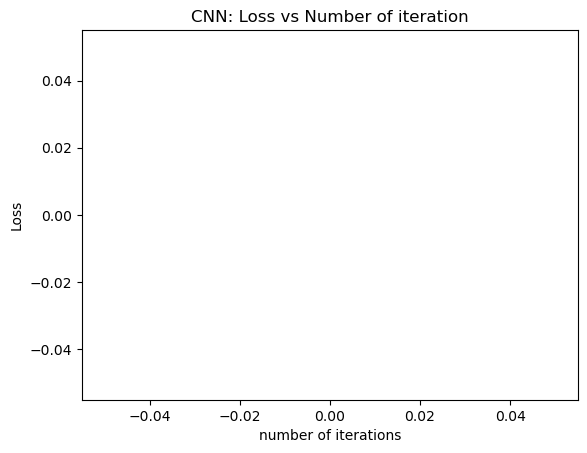

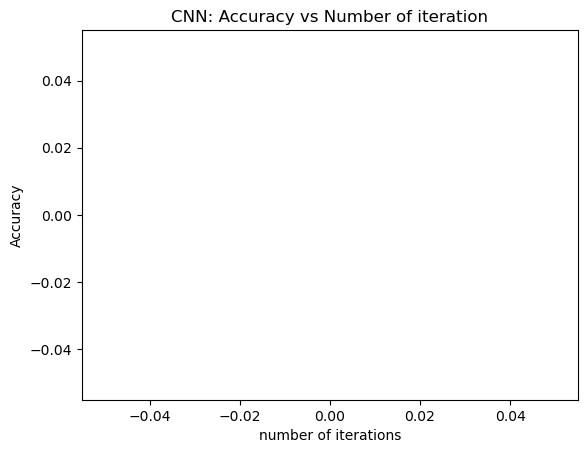

In [114]:
#visualization loss
plt.plot(iteration_list,new_loss_list)
plt.xlabel("number of iterations")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

#Visualization accuracy
plt.plot(iteration_list,new_accuracy_list, color ="red")
plt.xlabel("number of iterations")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [116]:
fracture_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        fracture_probs += list(zip(list(fileid), preds_list))

In [117]:
fracture_probs.sort(key = lambda x : int(x[0]))
fracture_probs

ValueError: invalid literal for int() with base 10: 'image1_1015_png'

In [ ]:
idx = list(map(lambda x: x[0],tumor_probs))
prob = list(map(lambda x: x[1],tumor_probs))

In [ ]:
submission = pd.DataFrame({'id':idx,'label':prob})
submission

In [ ]:
#save the result as a csv file
submission.to_csv('result.csv',index=False)

NameError: name 'submission' is not defined

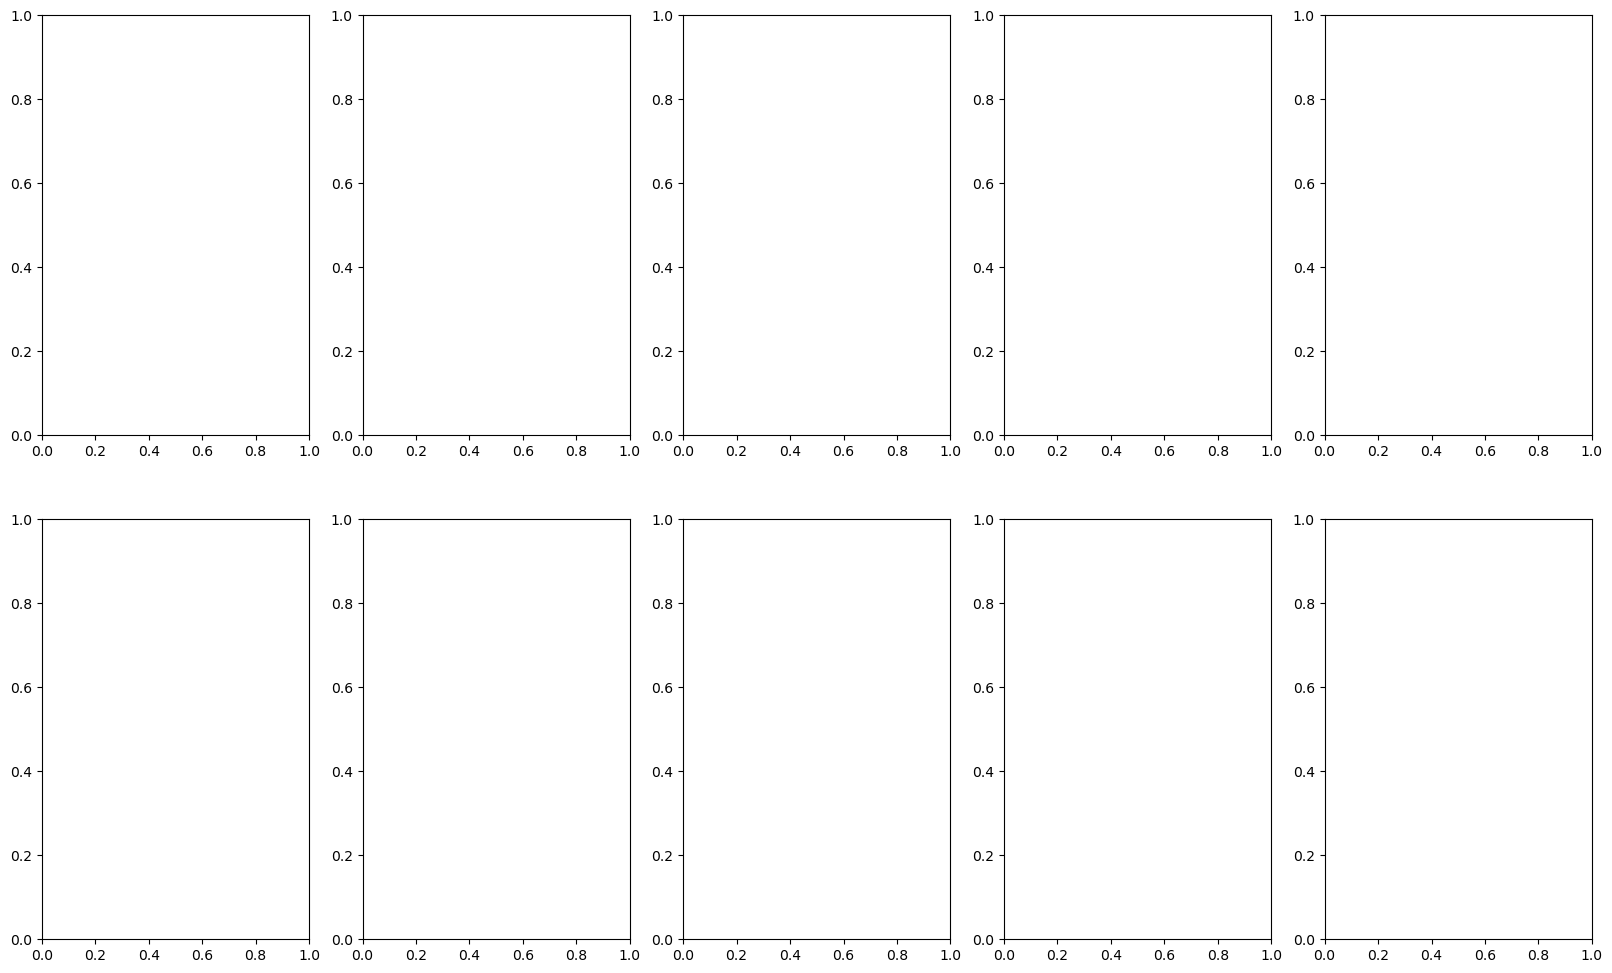

In [118]:
import random

id_list = []
class_ = {0: 'Tumor', 1: 'No tumor'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(base_dir, test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label], color = 'blue', weight='bold', fontsize=16)
    ax.imshow(img)